In [1]:
from google.colab import drive
drive.mount._DEBUG = True
drive.mount('/content/gdrive', force_remount=True)
root_path = 'gdrive/My Drive/Colab Notebooks/Classif_img_CNN/datas/'

unset HISTFILE; export PS1="root@efdf9d90efb7-a37782ee1a244cbc9cbfb43c55cf09ce: "
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/content# root@efdf9d90efb7-a37782ee1a244cbc9cbfb43c55cf09ce: umount -f /content/gdrive || umount /content/gdrive; pkill -9 -x drive
root@efdf9d90efb7-a37782ee1a244cbc9cbfb43c55cf09ce: pkill -9 -f /opt/google/drive/directoryprefetcher_binary
root@efdf9d90efb7-a37782ee1a244cbc9cbfb43c55cf09ce: ( while `sleep 0.5`; do if [[ -d "/content/gdrive" && "$(ls -A /content/gdrive)" != "" ]]; then echo "google.colab.drive MOUNTED"; break; fi; done ) &
[1] 1237
root@efdf9d90efb7-a37782ee1a244cbc9cbfb43c55cf09ce: cat /tmp/tmpnlkd76h5/drive.fifo | head -1 | ( /opt/google/drive/drive --features=fuse_max_background:1000,max_read_qps:1000,max_write_qps:1000,max_operation_batch_size:15,max_parallel_push_task_instances:10,opendir_timeout_ms:120000,virtual_folders_omit_spaces:true --inet_family=IPV4_ONLY --preferen

In [2]:
file = ''.join(root_path+'AnimalFace.zip')
file

'gdrive/My Drive/Colab Notebooks/Classif_img_CNN/datas/AnimalFace.zip'

In [3]:
!rm -rf datas
!mkdir datas
import zipfile
with zipfile.ZipFile(file,"r") as zip_ref:
    zip_ref.extractall("datas")

In [4]:
!rm '/content/datas/Image/DogHead/dog000590a.jpg'

In [5]:
!find . -name 'dog000590a.jpg'

In [6]:
src = '/content/datas/Image'
import os
from skimage.io import imread
for subdir in os.listdir(src):
    print(subdir)
    curent_path = os.path.join(src, subdir)
    new_path = os.path.join(src, subdir[:-4])
    os.rename(curent_path, new_path)
    nb = 0
    for file in os.listdir(new_path):
        if (file[-3:] in {'bmp', 'gif'}) or nb>100:
            print(os.path.join(new_path, file))
            os.remove(os.path.join(new_path, file))
        nb +=1

HumanHead
ElephantHead
BearHead
PigHead
TigerHead
/content/datas/Image/Tiger/tiger-tatiana.gif
/content/datas/Image/Tiger/tiger0000000157.jpg
/content/datas/Image/Tiger/tiger0000000150.jpg
/content/datas/Image/Tiger/tiger0000000768.jpg
/content/datas/Image/Tiger/tiger0000000761.jpg
/content/datas/Image/Tiger/tiger0000000083.jpg
/content/datas/Image/Tiger/tiger0000000129.jpg
/content/datas/Image/Tiger/tiger0000000193.jpg
/content/datas/Image/Tiger/tiger0000000080.jpg
/content/datas/Image/Tiger/tiger0000000186.jpg
/content/datas/Image/Tiger/tiger0000000010.jpg
/content/datas/Image/Tiger/tiger0000000537.jpg
/content/datas/Image/Tiger/tiger0000000029.jpg
/content/datas/Image/Tiger/tiger0000000173.jpg
Natural
DuckHead
/content/datas/Image/Duck/duckside0100.jpg
/content/datas/Image/Duck/duckside0020.jpg
EagleHead
DeerHead
/content/datas/Image/Deer/0000000061.jpg
/content/datas/Image/Deer/0000000036.jpg
WolfHead
SheepHead
MouseHead
CatHead
/content/datas/Image/Cat/cat1060a.bmp
/content/datas/

In [7]:
import tensorflow as tf

print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.4.1


## Create Dataset

In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [96]:
BATCH_SIZE = 64
IMG_SIZE = 150
src = './datas/Image' 

In [97]:
train_ds = image_dataset_from_directory(directory=src, 
                                        validation_split=0.1,
                                        subset='training',
                                        labels='inferred', 
                                        label_mode='categorical',
                                        seed=123,
                                        image_size=(IMG_SIZE, IMG_SIZE),
                                        batch_size=BATCH_SIZE)

Found 2016 files belonging to 21 classes.
Using 1815 files for training.


In [98]:
val_ds = image_dataset_from_directory(directory=src, 
                                        validation_split=0.1,
                                        subset='validation',
                                        labels='inferred', 
                                        label_mode='categorical',
                                        seed=123,
                                        image_size=(IMG_SIZE, IMG_SIZE),
                                        batch_size=BATCH_SIZE)



Found 2016 files belonging to 21 classes.
Using 201 files for validation.


header_size + row_size * abs_height

In [99]:
class_names = train_ds.class_names
print(class_names)

['Bear', 'Cat', 'Chicken', 'Cow', 'Deer', 'Dog', 'Duck', 'Eagle', 'Elephant', 'Human', 'Lion', 'Monkey', 'Mouse', 'Nat', 'Panda', 'Pig', 'Pigeon', 'Rabbit', 'Sheep', 'Tiger', 'Wolf']


## Preview images

In [100]:
import matplotlib.pyplot as plt


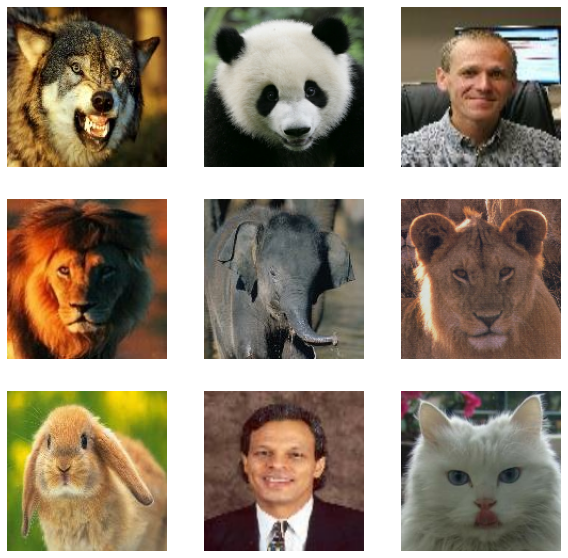

In [101]:
plt.figure(figsize=[10,10])
for image_batch, label_batch in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis("off")



In [102]:
image_batch.shape

TensorShape([64, 150, 150, 3])

In [103]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1024).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

Implementing data augmentation using keras.experimental.preprocessing.

Preprocessing the data and applying augmentation inside the model. This will apply preprocessing synchronously with the model execution, and on GPU. Also saves from implementing server-side logic for preprocessing.


In [104]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.2),
        tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    ], name="data_augmentation")



### Preview Augmentation

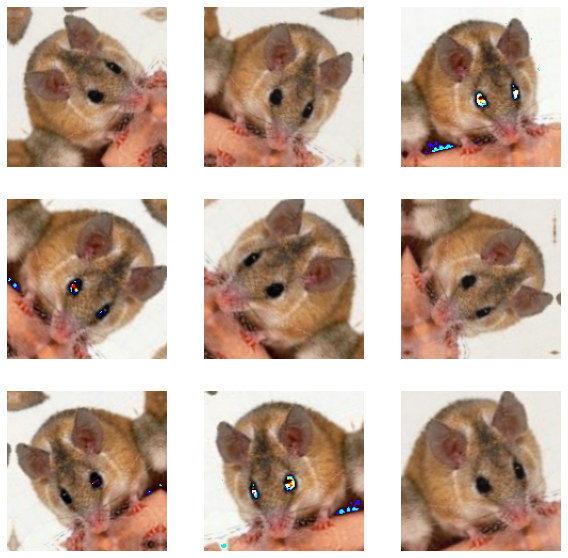

In [105]:
plt.figure(figsize=[10,10])
for image_batch, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(image_batch)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[2].numpy().astype('uint8'))
        plt.axis("off")

In [106]:
from keras.backend import clear_session
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense

## Build a model

In [107]:
from tensorflow import keras
from keras.backend import clear_session
import numpy as np

clear_session()

base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
for i in range(1):
    x = keras.layers.Dense(units=256, activation='elu')(x)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(len(class_names), activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544

### Train the top layer

In [108]:
# model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), ## True / False
# #model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), ## True / False
#              optimizer='adam',
#              metrics=['accuracy'])

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),  # Low learning rate
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

epochs = 20
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


Epoch 1/20
29/29 [==============================] - 17s 410ms/step - loss: 2.9143 - accuracy: 0.1934 - val_loss: 0.9820 - val_accuracy: 0.8806
Epoch 2/20
29/29 [==============================] - 10s 323ms/step - loss: 1.2292 - accuracy: 0.7100 - val_loss: 0.3783 - val_accuracy: 0.9552
Epoch 3/20
29/29 [==============================] - 10s 322ms/step - loss: 0.7683 - accuracy: 0.8211 - val_loss: 0.2188 - val_accuracy: 0.9851
Epoch 4/20
29/29 [==============================] - 10s 323ms/step - loss: 0.5574 - accuracy: 0.8591 - val_loss: 0.1595 - val_accuracy: 0.9851
Epoch 5/20
29/29 [==============================] - 10s 330ms/step - loss: 0.4957 - accuracy: 0.8803 - val_loss: 0.1308 - val_accuracy: 0.9851
Epoch 6/20
29/29 [==============================] - 10s 324ms/step - loss: 0.4375 - accuracy: 0.8888 - val_loss: 0.1100 - val_accuracy: 0.9851
Epoch 7/20
29/29 [==============================] - 10s 325ms/step - loss: 0.3733 - accuracy: 0.8976 - val_loss: 0.0979 - val_accuracy: 0.9851

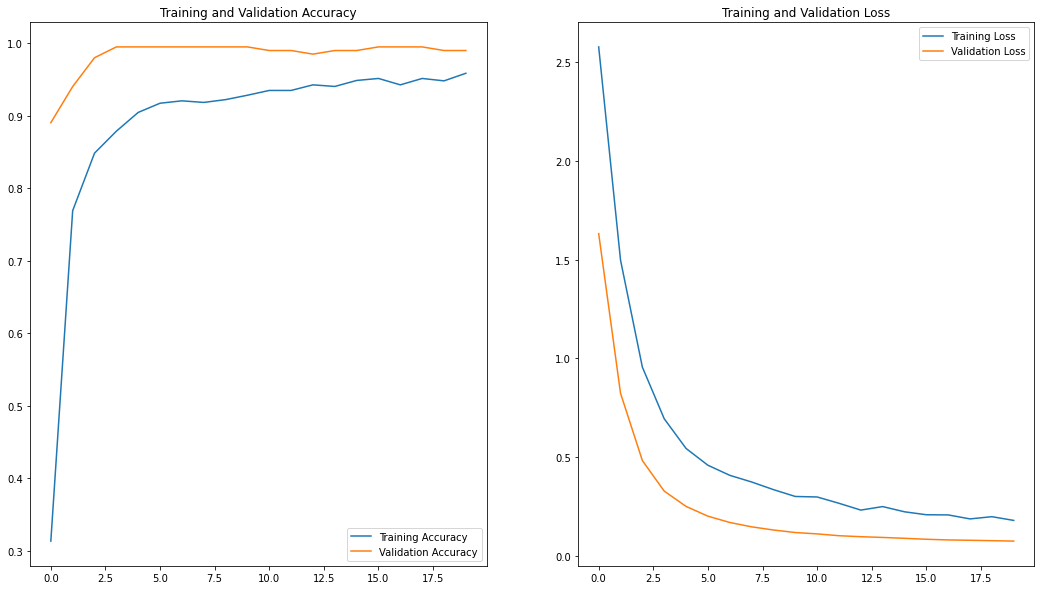

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
def plot_res(epochs_range, acc, val_acc, loss, val_loss):
    plt.figure(figsize=(18, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_res(epochs_range, acc, val_acc, loss, val_loss)

## Do a round of fine-tuning of the entire model

In [22]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.

base_model.trainable = True
model.summary()

# model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#              optimizer='adam',
#              metrics=['accuracy'])

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

epochs = 10
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, 256, 256, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 256, 256, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544

ResourceExhaustedError: ignored

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plot_res(epochs_range, acc, val_acc, loss, val_loss)

## Predict

In [43]:
import os, random

In [109]:
## rechercher au hasard des images dans le path

# dir_path = 'datas/Image/'
# class_label = random.choice(os.listdir("datas/Image/"))
# print("Class Label chosen: ", class_label)
# file = random.choice(os.listdir("datas/Image/"+class_label))
# print(file)

# file_path = dir_path + class_label + "/" + file
# print(file_path)

In [126]:
from skimage.transform import resize
from google.colab import files
image = files.upload()
print(image.keys())
for k, v in image.items(): pass

Saving OIP-ZrLva7w18PY4HH2YckooQgHaE8.jpeg to OIP-ZrLva7w18PY4HH2YckooQgHaE8.jpeg
dict_keys(['OIP-ZrLva7w18PY4HH2YckooQgHaE8.jpeg'])


(-0.5, 149.5, 149.5, -0.5)

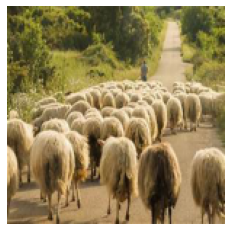

In [127]:
im = imread(k) # 333636a798.jpeg ## fda9a545f5.jpeg
im = resize(im, (IMG_SIZE, IMG_SIZE))
plt.imshow(im)
plt.axis('off')

In [128]:

img = tf.keras.preprocessing.image.load_img(k, target_size=(IMG_SIZE, IMG_SIZE, 3))

img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
print(img_array.shape)
predictions = model.predict(img_array)

print(predictions)

(1, 150, 150, 3)
[[1.5605768e-03 7.8606303e-05 2.1973895e-04 8.0942929e-02 3.5443802e-03
  5.5962725e-04 4.9242852e-03 1.1974833e-03 3.1569038e-02 9.7586904e-05
  4.0520090e-03 7.4578018e-04 1.3514659e-04 4.2889845e-03 2.0054549e-04
  1.0983831e-02 8.0917549e-04 1.8972702e-03 8.5172194e-01 3.0311890e-04
  1.6788977e-04]]


In [129]:
print(f"The prediction is '{class_names[np.argmax(predictions)]}' with a score of {np.max(predictions)*100:.2f}%")

The prediction is 'Sheep' with a score of 85.17%


In [119]:
print(class_names)

['Bear', 'Cat', 'Chicken', 'Cow', 'Deer', 'Dog', 'Duck', 'Eagle', 'Elephant', 'Human', 'Lion', 'Monkey', 'Mouse', 'Nat', 'Panda', 'Pig', 'Pigeon', 'Rabbit', 'Sheep', 'Tiger', 'Wolf']


In [119]:
file = ''.join(root_path+'animals.zip')
file

'gdrive/My Drive/Colab Notebooks/Classif_img_CNN/datas/animals.zip'

In [120]:
!mkdir datas
import zipfile
with zipfile.ZipFile(file,"r") as zip_ref:
    zip_ref.extractall("datas")

mkdir: cannot create directory ‘datas’: File exists


In [121]:
BATCH_SIZE = 64
IMG_SIZE = 150
src_test = './datas/raw-img'

In [122]:
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", \
             "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", \
             "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo", "ragno": "spider"}

In [123]:
import shutil
print(class_names)
for subdir in os.listdir(src_test):
    print(translate[subdir])
    curent_path = os.path.join(src_test, subdir) 
    print(curent_path)
    if translate[subdir].capitalize() not in class_names:
        print(subdir, "--> Not in the training set")
        shutil.rmtree(curent_path)
    else:
        new_path = os.path.join(src_test, translate[subdir].capitalize())
        os.rename(curent_path, new_path)

for dir in class_names:
    if dir not in os.listdir(src_test):
        new_path =  os.path.join(src_test, dir) 
        os.mkdir(new_path)

['Bear', 'Cat', 'Chicken', 'Cow', 'Deer', 'Dog', 'Duck', 'Eagle', 'Elephant', 'Human', 'Lion', 'Monkey', 'Mouse', 'Nat', 'Panda', 'Pig', 'Pigeon', 'Rabbit', 'Sheep', 'Tiger', 'Wolf']
spider
./datas/raw-img/ragno
ragno --> Not in the training set
chicken
./datas/raw-img/gallina
elephant
./datas/raw-img/elefante
cat
./datas/raw-img/gatto
squirrel
./datas/raw-img/scoiattolo
scoiattolo --> Not in the training set
butterfly
./datas/raw-img/farfalla
farfalla --> Not in the training set
horse
./datas/raw-img/cavallo
cavallo --> Not in the training set
cow
./datas/raw-img/mucca
sheep
./datas/raw-img/pecora
dog
./datas/raw-img/cane


In [124]:
test_ds = image_dataset_from_directory(directory=src_test, 
                                        labels='inferred', 
                                        label_mode='categorical',
                                        seed=123,
                                        image_size=(IMG_SIZE, IMG_SIZE),
                                        batch_size=BATCH_SIZE)

Found 14761 files belonging to 21 classes.


In [125]:
test_class_names = test_ds.class_names
print(test_class_names)

['Bear', 'Cat', 'Chicken', 'Cow', 'Deer', 'Dog', 'Duck', 'Eagle', 'Elephant', 'Human', 'Lion', 'Monkey', 'Mouse', 'Nat', 'Panda', 'Pig', 'Pigeon', 'Rabbit', 'Sheep', 'Tiger', 'Wolf']


In [122]:
y_pred = model.predict(val_ds, batch_size=BATCH_SIZE, use_multiprocessing=True) ## val_ds // test_ds
y_pred_class = np.argmax(y_pred, axis=1)
y_pred_class

array([ 2, 14,  1, 15,  5, 10,  0, 15,  6,  2,  7, 12,  8,  6, 11, 20, 10,
       20, 20,  4,  2,  1,  2, 20,  6, 11,  3, 15, 15,  5, 12, 16, 11,  5,
        0, 11, 20,  2,  3,  5, 20,  7, 12,  3, 17, 10,  6, 18,  1, 18,  9,
        4,  9, 17,  0, 19,  1, 15,  1,  0,  4,  2,  4,  8,  1,  6,  1,  7,
       19,  6,  9,  2, 16,  4, 15, 10,  0,  8, 18,  4,  6, 20,  4, 15, 16,
       17,  9,  0, 18,  4, 18, 18, 14,  9,  4,  5, 19, 14,  6, 19,  5, 10,
        8,  8,  5, 19, 12,  9,  8,  0, 16, 10,  3, 15, 16,  2, 10,  0, 16,
        5,  8,  5,  5, 17,  1,  0, 15, 14, 12,  4, 10,  9, 19,  4, 14,  4,
       14, 16,  8,  7,  6,  1,  9, 11, 19, 18,  9,  4,  4, 11,  4,  2,  8,
        4,  9, 11, 16, 16,  3, 15, 14, 20, 12, 11, 16,  0,  5, 17, 19,  0,
       14, 11,  6,  3,  6,  7,  4,  3,  8,  6, 18,  6, 10, 18,  6,  4, 13,
        7,  3,  3, 12,  0,  1,  6,  1, 11,  4, 15,  4, 11, 12, 11, 19, 20,
       16, 11,  0, 10, 19, 17, 15, 16,  4, 12,  3, 17, 18,  3,  6,  7,  0,
       14,  9,  4,  7, 18

In [123]:
y_pred.shape

(403, 21)

(403,)


Text(0.5, 1.0, 'Predicted probability variance distribution')

<Figure size 864x576 with 0 Axes>

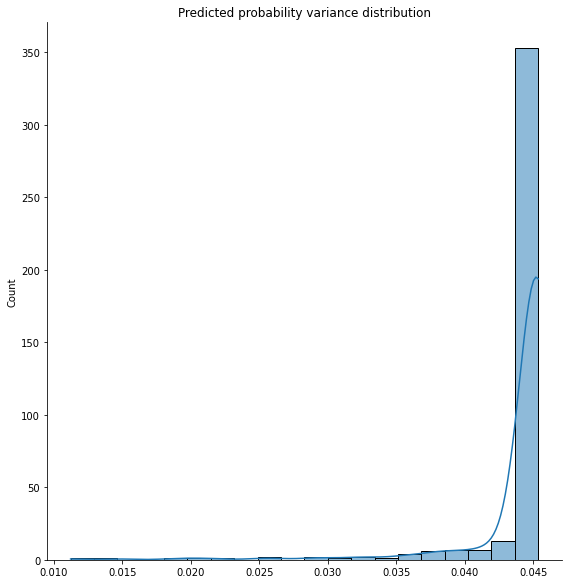

In [124]:
import seaborn as sns
variance_pred = np.var(y_pred, axis=1)
print(variance_pred.shape)

fig = plt.figure(figsize=[12,8])
sns.displot(x = variance_pred, bins=20, height=8, kde=True) ## , norm_hist=True
plt.title('Predicted probability variance distribution')

In [125]:
# y_pred_class = np.argmax(y_pred, axis=1)

# # iterator = test_ds.make_initializable_iterator()
# # feats, label = iterator.get_next()


# # img, labels = a.next()
# all_labels = np.array([])
# for elt in test_ds.as_numpy_iterator():
#     img, labels = elt
#     all_labels.append(labels[:])
# all_labels

In [126]:
test = np.array([[0.4, 0.6, 0.2], [2, 1, 1]])
test_one_hot = np.array([[1 if elt==max(pred) else 0 for elt in pred] for pred in test])
test_one_hot

array([[0, 1, 0],
       [1, 0, 0]])

In [127]:
labels = {value: idx for idx, value in enumerate(test_class_names)}
labels

{'Bear': 0,
 'Cat': 1,
 'Chicken': 2,
 'Cow': 3,
 'Deer': 4,
 'Dog': 5,
 'Duck': 6,
 'Eagle': 7,
 'Elephant': 8,
 'Human': 9,
 'Lion': 10,
 'Monkey': 11,
 'Mouse': 12,
 'Nat': 13,
 'Panda': 14,
 'Pig': 15,
 'Pigeon': 16,
 'Rabbit': 17,
 'Sheep': 18,
 'Tiger': 19,
 'Wolf': 20}

In [128]:
true_categories = tf.concat([y for x, y in val_ds], axis=0) ## val_ds // test_ds
true_categories

<tf.Tensor: shape=(403, 21), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [129]:
y_true = np.argmax(true_categories, axis=1)
y_true

array([ 7,  4,  5,  2,  6, 19, 15,  3,  4, 14,  0, 19,  2,  8, 11, 12,  6,
        9, 15, 10,  7, 14,  4,  4, 10, 15,  4, 16, 10, 15, 14,  7,  5,  9,
        0, 17,  3,  2,  5, 20,  3,  0,  0, 19,  4,  2,  9, 18,  4, 11,  3,
       18,  5, 17,  5,  7, 19, 16, 17, 16,  4, 11, 12,  7, 11, 11,  6, 20,
        5, 16, 15,  3, 20,  0, 20,  9, 19,  8, 19,  2, 15,  2,  0, 19,  6,
        0, 12, 11,  1, 10, 12, 12, 15,  7, 15,  0, 10, 10,  5,  0,  0,  5,
       20, 16, 11, 14,  4,  3,  7, 17, 14,  1,  5, 19,  4,  1,  8, 19, 17,
       12,  2, 20,  4, 11, 11, 18,  6,  9, 16, 20,  9,  1,  6,  4,  0,  5,
       19, 15,  5,  8, 19, 14,  4,  4, 14,  6, 15, 19, 10,  7, 16,  8, 19,
        5,  4,  0,  6,  9,  4,  1, 10,  9,  7, 11,  6,  8, 16, 19,  3, 15,
        6, 18, 11,  6, 17,  9, 10,  0,  3,  1,  8, 17, 12, 16, 14, 10,  4,
       10,  3, 14,  2, 17,  8, 16,  9, 17,  5,  9, 20,  9,  6,  4,  7, 11,
        1,  4, 16,  6, 12, 14,  8, 12, 14,  4,  4, 15,  6, 20, 19, 17, 17,
        6,  9, 14, 16,  9

In [130]:
y_pred_class

array([ 2, 14,  1, 15,  5, 10,  0, 15,  6,  2,  7, 12,  8,  6, 11, 20, 10,
       20, 20,  4,  2,  1,  2, 20,  6, 11,  3, 15, 15,  5, 12, 16, 11,  5,
        0, 11, 20,  2,  3,  5, 20,  7, 12,  3, 17, 10,  6, 18,  1, 18,  9,
        4,  9, 17,  0, 19,  1, 15,  1,  0,  4,  2,  4,  8,  1,  6,  1,  7,
       19,  6,  9,  2, 16,  4, 15, 10,  0,  8, 18,  4,  6, 20,  4, 15, 16,
       17,  9,  0, 18,  4, 18, 18, 14,  9,  4,  5, 19, 14,  6, 19,  5, 10,
        8,  8,  5, 19, 12,  9,  8,  0, 16, 10,  3, 15, 16,  2, 10,  0, 16,
        5,  8,  5,  5, 17,  1,  0, 15, 14, 12,  4, 10,  9, 19,  4, 14,  4,
       14, 16,  8,  7,  6,  1,  9, 11, 19, 18,  9,  4,  4, 11,  4,  2,  8,
        4,  9, 11, 16, 16,  3, 15, 14, 20, 12, 11, 16,  0,  5, 17, 19,  0,
       14, 11,  6,  3,  6,  7,  4,  3,  8,  6, 18,  6, 10, 18,  6,  4, 13,
        7,  3,  3, 12,  0,  1,  6,  1, 11,  4, 15,  4, 11, 12, 11, 19, 20,
       16, 11,  0, 10, 19, 17, 15, 16,  4, 12,  3, 17, 18,  3,  6,  7,  0,
       14,  9,  4,  7, 18

In [131]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_class, target_names=test_class_names))

              precision    recall  f1-score   support

        Bear       0.10      0.10      0.10        21
         Cat       0.00      0.00      0.00        17
     Chicken       0.07      0.07      0.07        15
         Cow       0.05      0.05      0.05        19
        Deer       0.10      0.09      0.10        32
         Dog       0.00      0.00      0.00        25
        Duck       0.05      0.05      0.05        21
       Eagle       0.00      0.00      0.00        17
    Elephant       0.05      0.05      0.05        22
       Human       0.06      0.06      0.06        18
        Lion       0.00      0.00      0.00        18
      Monkey       0.13      0.14      0.13        22
       Mouse       0.00      0.00      0.00        19
         Nat       0.00      0.00      0.00         1
       Panda       0.10      0.10      0.10        21
         Pig       0.00      0.00      0.00        23
      Pigeon       0.00      0.00      0.00        19
      Rabbit       0.06    

In [132]:
from sklearn.metrics import confusion_matrix
confusionMatrix = confusion_matrix( y_true, y_pred_class)

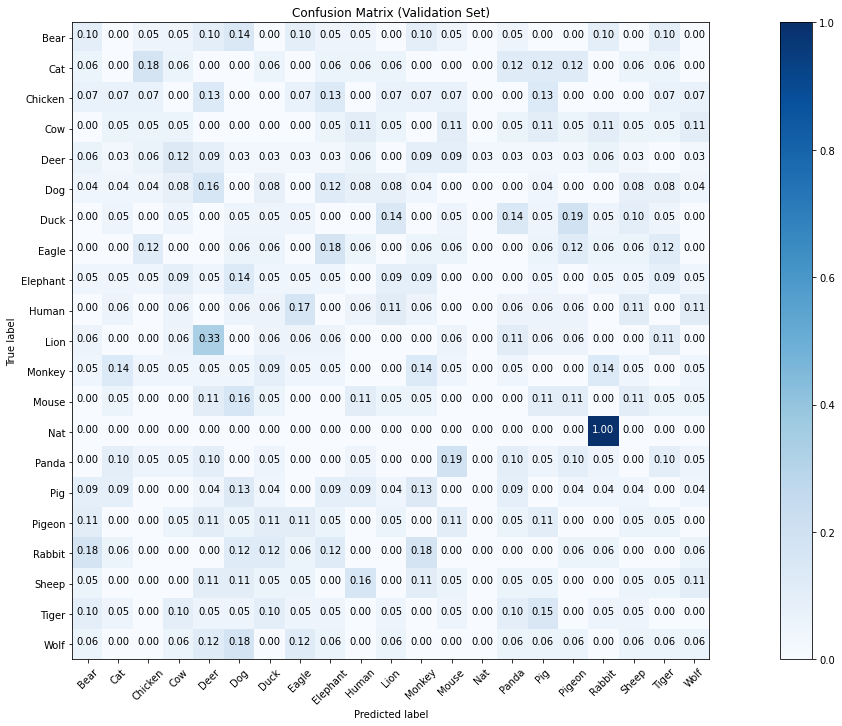

In [133]:
import itertools
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.savefig('./figures/conf_matrix.png')

plt.figure(figsize=(20,10))
plot_confusion_matrix(confusionMatrix, labels=test_class_names)

In [134]:
X_train = np.empty(shape=(0, IMG_SIZE, IMG_SIZE, 3))
y_train = np.empty(shape=(0, 21))
for elt in train_ds.as_numpy_iterator():
    X_train = np.concatenate((X_train, elt[0]), axis=0)
    y_train = np.concatenate((y_train, elt[1]), axis=0)

print(X_train.shape)
print(y_train.shape)

(1613, 299, 299, 3)
(1613, 21)


## Grid search

In [ ]:
def create_model(dropout, ):
    base_model = keras.applications.Xception(
        weights="imagenet",  # Load weights pre-trained on ImageNet.
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
    )  # Do not include the ImageNet classifier at the top.

    # Freeze the base_model
    base_model.trainable = False

    # Create new model on top
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)  # Apply random data augmentation

    # Pre-trained Xception weights requires that input be normalized
    # from (0, 255) to a range (-1., +1.), the normalization layer
    # does the following, outputs = (inputs - mean) / sqrt(var)
    norm_layer = keras.layers.experimental.preprocessing.Normalization()
    mean = np.array([127.5] * 3)
    var = mean ** 2
    # Scale inputs to [-1, +1]
    x = norm_layer(x)
    norm_layer.set_weights([mean, var])

    # The base model contains batchnorm layers. We want to keep them in inference mode
    # when we unfreeze the base model for fine-tuning, so we make sure that the
    # base_model is running in inference mode here.
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(dropout)(x)  # Regularize with dropout
    outputs = keras.layers.Dense(len(class_names), activation='softmax')(x)
    model = keras.Model(inputs, outputs)

    model.summary()
    return model


In [51]:
from keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn=create_model)

NameError: ignored